# Submission

## load package

In [1]:
import sys
import pandas as pd

from keras.applications import xception
from keras.applications import resnet50
from keras.applications import mobilenetv2
# from efficientnet import EfficientNetB3

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Softmax
from keras.preprocessing import image

from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, K
from keras.models import Input, Model
from sklearn.metrics import f1_score

from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import gc


Using TensorFlow backend.


In [2]:
cache=False
bKaggle = False
datadir = './'
# datadir = './data_carmodel/'
inputdir='./'
if bKaggle:
    datadir = '../input/carmodel8/data_carmodel/'
    inputdir = '../input/2019-3rd-ml-month-with-kakr/'

imgwidth=299
imgheight=299
# get_ipython().run_line_magic('matplotlib', 'inline')

def dbgprint(msg):
    if bKaggle:
        os.system('echo "'+msg+'"')
    else:
        print(msg)

dbgprint('hello log')

hello log


In [3]:
# x_trainall = np.load(datadir+'x_train.npy')
# y_trainall = np.load(datadir+'y_train.npy')
# dfclass = pd.read_csv(inputdir+'class.csv')
# y_trainall_onehot = np_utils.to_categorical(y_trainall, 196)

In [4]:
# f1 score 
def new_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Predict

In [5]:
# test data load for submission
x_test = np.load(datadir+'x_test3.npy')
x_test = x_test/255.

In [6]:
if True:
    import glob, os
    
    predictions=[]
    
    # 'carmodel-v8-1-', 
#     for ff, mp in enumerate(['carmodel-v8-6-', 'carmodel-v8-7-', 'carmodel-v8-8-']):
    for ff, mp in enumerate(['carmodel-v9-1-', 'carmodel-v9-2-', 'carmodel-v9-3-']):
        files = glob.glob(datadir+mp+'*')
        mp = max(files, key=os.path.getctime)
        msg = '{} model={}'.format(ff, mp)
        dbgprint(msg)
        
        method='xception'
        if mp.find('resnet50')>0:
            method = 'resnet50'
        elif mp.find('mobilenetv2')>0:
            method = 'mobilenetv2'
        elif mp.find('efficientnetb3')>0:
            method = 'efficientnetb3'
        
        inputs = Input(shape=(imgheight,imgwidth,3))
        print('method=', method)
        if method=='xception':
            net = xception.Xception(input_tensor=inputs, input_shape=(imgheight, imgwidth, 3), include_top=False, weights='imagenet', pooling='max')
        elif method=='resnet50':
            net = resnet50.ResNet50(input_tensor=inputs, input_shape=(imgheight, imgwidth, 3), include_top=False, weights='imagenet', pooling='max')
        elif method=='mobilenetv2':
            net = mobilenetv2.MobileNetV2(input_tensor=inputs, input_shape=(imgheight, imgwidth, 3), include_top=False, weights='imagenet', pooling='max')
        elif method=='efficientnetb3':
            net = EfficientNetB3(input_tensor=inputs, input_shape=(imgheight, imgwidth, 3), include_top=False, weights='imagenet', pooling='max')
        
        net2 = Dense(256, activation='relu') (net.layers[-1].output)
        net2 = Dense(196)(net2)
        net2 = Softmax(196)(net2)
        model = Model(inputs=inputs, outputs=net2)
        
        print('model',ff,':', mp)
        model.load_weights(mp)
        
        pr = model.predict( x_test )
        predictions.append(pr)
        print('prediction',ff,':',pr)
        
    predictions = np.asarray(predictions)
    prk = np.mean(predictions, axis=0 )
    pdi = np.argmax(prk, axis=1)
    print('final:', pdi, np.min(pdi), np.max(pdi))

0 model=./carmodel-v8-6-xception-001-0.9531.ckpt
method= xception
Instructions for updating:
Colocations handled automatically by placer.
model 0 : ./carmodel-v8-6-xception-001-0.9531.ckpt
prediction 0 : [[1.57202766e-08 0.00000000e+00 1.05892388e-34 ... 2.94653910e-16
  1.98252953e-28 1.40032388e-25]
 [1.28739894e-20 2.59733017e-13 2.96907884e-14 ... 8.25662780e-13
  6.45939292e-12 4.21189444e-10]
 [2.22926700e-32 4.51230763e-31 2.77766524e-29 ... 4.53996795e-31
  1.16263486e-21 5.07563918e-19]
 ...
 [3.28245630e-32 6.57135068e-22 5.94611110e-27 ... 2.16968856e-23
  9.77427936e-27 1.99420064e-33]
 [0.00000000e+00 2.36412791e-29 3.50305652e-29 ... 1.72612309e-33
  3.26393018e-26 9.93112577e-29]
 [1.03540095e-22 1.55280102e-18 8.63699861e-20 ... 1.76379087e-22
  7.26919017e-15 1.16272364e-18]]
1 model=./carmodel-v8-7-xception-001-0.9537.ckpt
method= xception
model 1 : ./carmodel-v8-7-xception-001-0.9537.ckpt
prediction 1 : [[2.88670230e-06 3.44964052e-22 6.08968661e-19 ... 5.90048273e-0

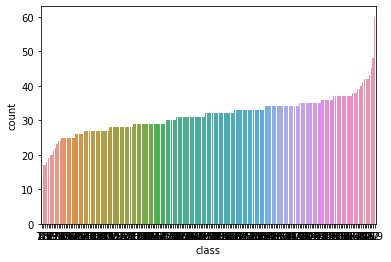

In [7]:
if True:
    submission = pd.read_csv(inputdir+'sample_submission.csv')
    submission["class"] = pdi + 1  
    submission.to_csv("submission.csv", index=False)
    submission.head()


# In[17]:
sns.countplot(submission["class"], order=submission["class"].value_counts(ascending=True).index)

In [8]:
dfpredictions = pd.DataFrame(np.max(prk, axis=1).squeeze() )
dfpredictions.describe()

,0
count,6150.000000
mean,0.867693
std,0.207561
min,0.078997
25%,0.783467
50%,0.993280
75%,0.999884
max,1.000000


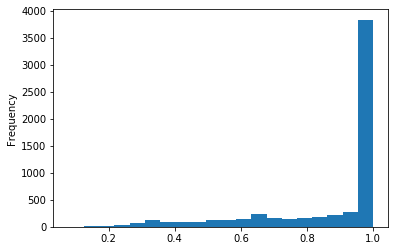

In [9]:
dfpredictions[0].plot.hist(bins=20)

In [10]:
psids = dfpredictions[0]>0.99 
np.sum(psids)

3216

In [11]:
x_test.shape
x_test[psids].shape

(3216, 224, 224, 3)

In [12]:
# pseudo dataset
# x_test[psids]
# pdi[psids]
# make pseudo
if False:
    print('Create Pseudo Label')
    x_test = np.load(datadir+'x_test3.npy')
    np.save('x_pseudo3.npy', x_test[psids])
    np.save('y_pseudo3.npy', pdi[psids])

In [13]:
x_test[0].dtype

dtype('float64')